<a href="https://colab.research.google.com/github/kanisshka23/Deep-learning-/blob/main/COCOdataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install the necessary libraries
!pip install torch torchvision matplotlib pycocotools


In [ ]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.datasets import CocoDetection
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# Download the COCO dataset using wget (Train 2017 images + annotations)
!wget http://images.cocodataset.org/zips/train2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

# Unzip the dataset
!unzip -q train2017.zip
!unzip -q annotations_trainval2017.zip


--2024-10-09 05:04:17--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.89.252, 52.217.161.193, 3.5.10.117, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.89.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G   111MB/s    in 3m 14s  

2024-10-09 05:07:30 (95.2 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]

--2024-10-09 05:07:30--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.138.35, 3.5.25.25, 3.5.27.252, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.138.35|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_tra

In [ ]:
class CocoDataset(CocoDetection):
    def __init__(self, root, annFile, transform=None):
        super().__init__(root, annFile)
        self.transform = transform

    def __getitem__(self, idx):
        img, targets = super().__getitem__(idx)

        # Convert the image to a tensor
        img = F.to_tensor(img)

        if self.transform:
            img, targets = self.transform(img, targets)

        return img, targets


In [ ]:
# Define dataset paths
train_img_dir = 'train2017/'
train_ann_file = 'annotations/instances_train2017.json'

# Create COCO dataset and DataLoader
train_dataset = CocoDataset(root=train_img_dir, annFile=train_ann_file)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))


loading annotations into memory...
Done (t=29.34s)
creating index...
index created!


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# Load pre-trained Faster R-CNN with ResNet-50 backbone
model = fasterrcnn_resnet50_fpn(pretrained=True)

# Change the number of classes (COCO has 80 classes + background)
num_classes = 91  # 80 classes + background

# Modify the model's classifier to fit the COCO dataset
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 145MB/s]


In [ ]:
import time
import torch

# Utility function to print debug information about data batches
def debug_batch_structure(images, targets, batch_idx):
    print(f"Batch {batch_idx}:")
    print(f"  Type of images: {type(images)}")
    print(f"  Type of targets: {type(targets)}")

    if isinstance(targets, tuple):
        print(f"  Targets are a tuple with {len(targets)} elements.")
        for idx, t in enumerate(targets):
            print(f"    Target {idx} type: {type(t)} - {t}")
    elif isinstance(targets, list):
        print(f"  Targets are a list with {len(targets)} elements.")
        for idx, t in enumerate(targets):
            print(f"    Target {idx} type: {type(t)} - {t}")
    else:
        print("  Targets are of an unknown format.")

# Move the target tensors to the correct device
def move_targets_to_device(targets, device):
    if isinstance(targets, list):
        return [{k: v.to(device) if torch.is_tensor(v) else v for k, v in t.items()} for t in targets]
    elif isinstance(targets, dict):
        return {k: v.to(device) if torch.is_tensor(v) else v for k, v in targets.items()}
    return targets

# Function for training one epoch
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10):
    model.train()  # Set model to training mode
    metric_logger = {'loss': 0}
    start_time = time.time()

    for batch_idx, (images, targets) in enumerate(data_loader):
        # Debugging: print batch structure for the first 5 batches
        if batch_idx < 5:
            debug_batch_structure(images, targets, batch_idx)

        # Move images and targets to the device
        images = [image.to(device) for image in images]
        targets = move_targets_to_device(targets, device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        loss_dict = model(images, targets)

        # Compute the total loss
        total_loss = sum(loss for loss in loss_dict.values())

        # Backward pass and optimization
        total_loss.backward()
        optimizer.step()

        # Update loss metrics
        metric_logger['loss'] += total_loss.item()

        # Print training stats periodically
        if (batch_idx + 1) % print_freq == 0:
            print(f"Epoch {epoch}, Batch {batch_idx + 1}, Loss: {total_loss.item():.4f}")

    print(f"Epoch {epoch} training complete. Total Loss: {metric_logger['loss']:.4f}")
    return metric_logger

# Main training loop
def train_model(model, train_loader, num_epochs=10, lr=0.005, momentum=0.9, weight_decay=0.0005, step_size=3, gamma=0.1):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Set up the optimizer and learning rate scheduler
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=lr, momentum=momentum, weight_decay=weight_decay)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    # Training loop
    for epoch in range(num_epochs):
        print(f"Starting epoch {epoch + 1}/{num_epochs}")
        train_one_epoch(model, optimizer, train_loader, device, epoch + 1)
        lr_scheduler.step()

    print("Training complete.")

# Example usage
# train_model(model, train_loader)




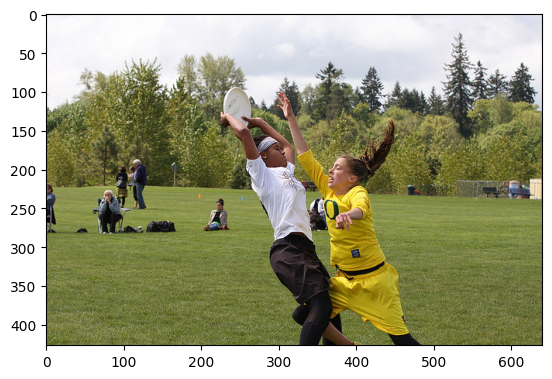

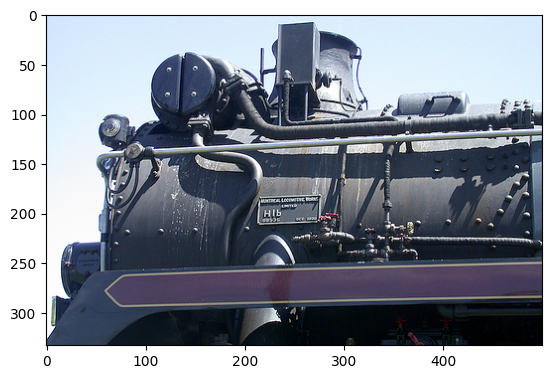

In [ ]:
 #Evaluate the model on a few images
model.eval()
images, targets = next(iter(train_loader))

with torch.no_grad():
    prediction = model([img.to(device) for img in images])

# Plot the results
def plot_results(images, prediction):
    for img, pred in zip(images, prediction):
        plt.imshow(img.permute(1, 2, 0).cpu())
        boxes = pred['boxes'].cpu().numpy()
        scores = pred['scores'].cpu().numpy()
        labels = pred['labels'].cpu().numpy()

        # Display boxes and labels
        for box, score, label in zip(boxes, scores, labels):
            if score > 0.5:  # Thresholding based on confidence
                plt.gca().add_patch(plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='r', facecolor='none'))
                plt.text(box[0], box[1], f'{label}: {score:.2f}', color='red', fontsize=12)
        plt.show()

plot_results(images, prediction)


In [ ]:
from pycocotools.coco import COCO

# Load the COCO validation dataset
val_img_dir = 'val2017/'
val_ann_file = 'annotations/instances_val2017.json'

val_dataset = CocoDataset(root=val_img_dir, annFile=val_ann_file)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))



loading annotations into memory...
Done (t=0.99s)
creating index...
index created!
